<a href="https://colab.research.google.com/github/HoomanKhosravi/ImageSegmentation_Human_PyTourch_Unet/blob/main/ImageSegmentation_Human_PyTourch_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

#Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [5]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


#Imports

In [6]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [7]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

#Setup Configurations

In [8]:
TRAIN_CSV = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

DEVICE = 'cuda'

EPOCHS = 25
LEARNING_RATE = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'



In [9]:
df = pd.read_csv(TRAIN_CSV)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [10]:
row = df.iloc[1]
mask_dir = row.masks
image_dir = row.images

image = cv2.imread(image_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE)/ 255.0 

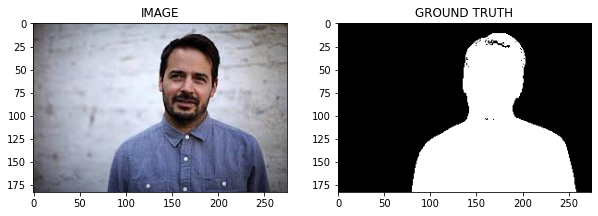

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [12]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 32)


#Augmentation

albumentation documentation : https://albumentations.ai/docs/

In [13]:
import albumentations as alb

In [14]:
def get_train_augs():
  return alb.compose([
    alb.Resize(IMAGE_SIZE, IMAGE_SIZE),
    alb.HorizontalFlip(p = 0.5),
    alb.VerticalFlip(p = 0.5)
  ])
def get_test_augs():
  return alb.compose([
    alb.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ])



# Create Custom Dataset 

In [16]:
from torch.utils.data import Dataset

In [18]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getItem__(self, idx):
    row = self.df.iloc[idx]
    
    mask_dir = row.masks
    image_dir = row.images

    image = cv2.imread(image_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_dir, cv2.IMREAD_GRAYSCALE) 
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = torch.round( torch.Tensor(mask)/255.0 )

    return image, mask
    



In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

#Load dataset into batches

# Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

#Create Train and Validation Function 

#Train Model

#Inference